# Load in data inspect some basic information

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# read in csv 
df = pd.read_csv('data/df_final_2023_08_25')
# shape 
print("Shape: ", df.shape)

Shape:  (907485, 16)


In [2]:
print("Set the printing size of the pandas df: ")
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Set the printing size of the pandas df: 


In [3]:
print("Deleting the discontious SCC where period_index==-1")
print("Shape: ", df.shape)
df = df[df["period_index"] != -1]
print("Shape: ", df.shape)

Deleting the discontious SCC where period_index==-1
Shape:  (907485, 16)
Shape:  (671868, 16)


In [4]:
print("Shift scc to the first column")
# shift column 'scc' to first position
first_column = df.pop('scc')
# insert column using insert(position,column_name, first_column) function
df.insert(0, 'scc', first_column)

Shift scc to the first column


In [5]:
print("For convinent, make milkng_date the string")
milkng_date_only = df['milkng_date'].apply(lambda x: str(x))
df['milkng_date_only'] = milkng_date_only

For convinent, make milkng_date the string


In [6]:
print("shape: ", df.shape)
df.head()

shape:  (671868, 17)


,scc,mk_wgt,min_time,var_time,milk_flow_max,ft_pcnt,pt_pcnt,milkng_temp,cow_info,anm_ida,hrd_ida,prep_time,milkng_date,dim,period_index,no_visit,milkng_date_only
13,69.0,8.5,1.716667,0.021667,4.8,4.456311,3.180291,38.200000,5.0,1,4,4.016667,20220101,247.0,12,2,20220101
14,84.0,37.5,1.583333,0.079074,5.6,4.211165,3.124466,38.050000,5.0,1,4,3.316667,20220102,248.0,12,2,20220102
15,84.0,29.4,1.500000,0.210926,5.2,4.449838,3.070259,38.166667,5.0,1,4,4.016667,20220103,249.0,12,2,20220103
16,88.0,33.6,1.633333,0.219884,5.8,4.433657,3.096149,38.200000,5.0,1,4,3.755556,20220104,250.0,12,2,20220104
17,482.0,30.0,1.533333,0.081574,7.2,4.446602,3.050841,38.466667,5.0,1,4,3.611111,20220105,251.0,12,2,20220105


In [7]:
# ingore future warning
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)
# surprass chain warning
pd.set_option('mode.chained_assignment', None)
#warnings.filterwarnings("ignore", message=r"Passing", category=SettingWithCopyWarning)

test for a function of variance


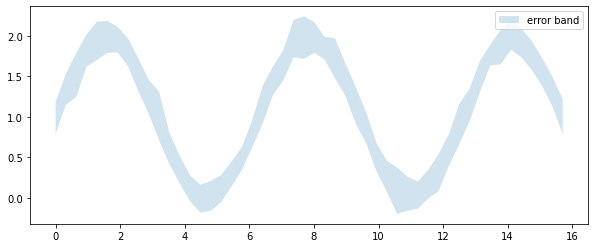

In [8]:
print("test for a function of variance")
# from: https://stackoverflow.com/questions/55368485/draw-error-shading-bands-on-line-plot-python

import numpy as np                 # v 1.19.2
import matplotlib.pyplot as plt    # v 3.3.2

rng = np.random.default_rng(seed=1)

x = np.linspace(0, 5*np.pi, 50)
y = np.sin(x)
# error = np.random.normal(0.1, 0.02, size=x.shape) # I leave this out
nb_yfuncs = 25
ynoise = rng.normal(1, 0.1, size=(nb_yfuncs, y.size))
yfuncs = nb_yfuncs*[y] + ynoise

ymean = yfuncs.mean(axis=0)
ymin = yfuncs.min(axis=0)
ymax = yfuncs.max(axis=0)
yerror = np.stack((ymean-ymin, ymax-ymean))

fig, ax = plt.subplots(figsize=(10,4))
plt.fill_between(x, ymin, ymax, alpha=0.2, label='error band')
plt.legend()

plt.show()

# Visualization (2023-09-07)

### De-trending: correcting for dim and milkng_date_only

In [9]:
print("Pick an herd to test functions..")
df_4 = df[df['hrd_ida']==4]

Pick an herd to test functions..


### Create X (numpy 2d array (days, variable)) and y (binary indicator for mastitis)

In [9]:
"""
method: 
    to label the days by the period before SCC 
args: 
    scc_ls: list[int]
    period: int
    threshold: int
return: 
    results: a list with label days 0 to period
"""
def count_down(scc_ls, period, threshold): 
    # reverse the list 
    re_ls = scc_ls[::-1]
    # set a count 
    count = period
    # init result  
    result = [] 
    
    # looping 
    for i in range(len(re_ls)): 
        # if find larger than 
        if re_ls[i] >= threshold:
            # let count equals zero 
            count = 0
            result.append(count)
            count += 1
        # if smaller than thresold
        else: 
            result.append(count) 
            count += 1
        
    # print("result: ", result)
    # restriant the number below period
    result = [period if i >= period else i for i in result]
    
    # return reversed
    return result[::-1]

In [10]:
""" 
func: 
    to find the start and end index of valid period 
args: 
    ls_dim: list[float] 
    ls_period_index: list[int] 
return: 
    ls_index: a list of start and end index of this cow: list[int]
"""
def find_valid_perod(ls_dim, ls_period_index): 
    
    # check the length of ls_dim 
    if len(ls_dim) <= 2: 
        return [0, len(ls_dim)]
        
    # init result and append the start index
    ls_index = [0]  
    
    # loop through the two input lists 
    for i in range(len(ls_dim)-1): 
        # if dim jumped or period index changed 
        if ((ls_dim[i+1] - 1) != ls_dim[i]) or (ls_period_index[i+1] != ls_period_index[i]): 
            # append new end index 
            ls_index.append(i) 
            
    # check for the last element  
    if (ls_dim[-1]-1 == ls_dim[-2]) and (ls_period_index[-1] == ls_period_index[-2]): 
        # append the last 
        ls_index.append(len(ls_dim))
        
    return ls_index
    

In [11]:
""" 
helper function for create_model_input

args: 
    X, y: list[numpy array that will be update dynamically]
    one_cow: dataframe 
    days_before: days_before_scc as a list 
    period: int 

return: 
    not returning but update X and y dynamically
"""
def create_one_cow(X, y, one_cow, days_before, period): 

    # init target time window, period where mastitis occurs
    # e.g. [13, 12, 11, 10, 9, 8, 7, 6, 5, ...0]
    mastitis_period = [i for i in range(period-1, -1, -1)]

    # init pointer  
    i = 0 
    # loop through the list 
    while i <= len(days_before): 
        try:
            # check if it is a healthy period,  
            if days_before[i] == period: 
                # check for the following period 
                time = days_before[i: i+period]
                if len(set(time)) == 1 and len(time) == period: 
                    
                    # create example with label 0 
                    X.append(one_cow.iloc[i:i+period, :])
                    y.append(0) 
                    
                    """move the pointer time_period steps, note that here we move 14 because consider 14 as a recovery phase"""
                    i += 14
                    
            # if it is not all healthy case
            else: 
                # check for the following 14 period
                if days_before[i:i+period] == mastitis_period: 
                    
                    # create example with label 1
                    X.append(one_cow.iloc[i:i+period, :])
                    y.append(1) 
                    # move the pointer 14 steps
                    i += period
                    
            # increment pointer 
            i += 1 
            
        except IndexError: 
            # to terminate the function
            i = float('inf')


In [12]:
""" 
func: 
    loop through cows and chunking 
args: 
    df_stded: dataframe
    period: int
    threshold: int
    predictors: list[str]
return: 

"""
def chunk_herd(df_stded, period, threshold, predictors):
    
    # list of cow id 
    ls_cow_id = df_stded['anm_ida'].unique().tolist() 
    # init X, y
    X, y = [], [] 
    
    # looping cow id 
    for idx in ls_cow_id:
        
        # obtain cow data by index
        df_cow = df_stded[df_stded['anm_ida']==idx]

        """using func: find_valid_perod"""
        ls_index = find_valid_perod(df_cow['dim'].tolist(), df_cow['period_index'].tolist())

        # loop through ls_index for each valid period 
        for idx in range(len(ls_index)-1):
        
            # obtain a period from ls_index 
            valid_period = df_cow.iloc[ls_index[idx]:ls_index[idx+1], :]
            
            # retain variables interested in only 
            valid_period = valid_period[predictors]
            
            # obtain scc list 
            scc_ls = valid_period['scc'].tolist() 
            
            """using func: count_down"""
            days_before = count_down(scc_ls, period, threshold)
            
            """using func: create_one_cow(X, y, one_cow, days_before, period)"""
            create_one_cow(X, y, valid_period, days_before, period)
        
    return np.array(X), np.array(y)

In [13]:
print("setting predictors, period, threshold...")
predictors = ['scc', 'mk_wgt', 'min_time', 'var_time', 'milk_flow_max', 'ft_pcnt', 'pt_pcnt', 'milkng_temp', 'cow_info', 'prep_time', 'no_visit']
period, threshold = 14, 2000

setting predictors, period, threshold...


In [14]:
print("creating X_df, y_df...")
X_df, y_df = chunk_herd(df, period, threshold, predictors)
print("X_df, y_df: ", X_df.shape, y_df.shape)

creating X_df, y_df...
X_df, y_df:  (37117, 14, 11) (37117,)


# Plot X, and y with each variable and perform t-test for each day

In [15]:
"""
method: 
    helper function for visual_by_group
args: 
    t_test: list[int]
    alpha: float
return: 
    result: list[int]
"""
def compare_alpha(t_test, alpha): 
    # reverse 
    t = t_test[::-1]
    # init result 
    result = [] 
    # loop and compare
    for i in range(len(t)): 
        if t[i] < alpha: 
            result.append(i)
    return result


"""
func: 
    preform t-test and connects pairs
arg: 
    plt: pyplot object
    neg_days: list[list]
    pos_days: list[list]
    ave_neg_days: list[int]
    ave_pos_days: list[int]
    alpha = 0.005
return: 
    connect pairs
"""
def perform_t_test(plt, neg_days, pos_days, ave_neg_days, ave_pos_days, alpha = 0.05, MARKER='o'):
    
    
    ## set the markers between mastitis and health group
    t_test = [] 
    for i in range(len(neg_days)): 
        t_value, p_value = stats.ttest_ind(neg_days[i], pos_days[i])
        t_test.append(p_value)

    ## set the markers for mastitis  
    t_test_mastitis = [] 
    for i in range(len(pos_days)): 
        # compare with the 13th day prior to mastitis
        t_value, p_value = stats.ttest_ind(pos_days[0], pos_days[i])
        t_test_mastitis.append(p_value)

    """using func: compare_alpha"""
    markers_on = compare_alpha(t_test, alpha)
    """using func: compare_alpha"""
    markers_on_mastitis = compare_alpha(t_test_mastitis, alpha)
    # to connect the siginificant point comparing health and mastitis group
    for i in range(len(markers_on)): 
        x_value = [markers_on[i], markers_on[i]]
        y_value = [ave_neg_days[markers_on[i]], ave_pos_days[markers_on[i]]]
        #print("x_value, y_value: ", x_value, y_value)
        plt.plot(x_value, y_value, marker=MARKER, linestyle="--", color="forestgreen")

    # to connect the siginificant point compare mastitis group (12th-0th days) with their 13th day
    for i in range(len(markers_on_mastitis)): 
        x_value_mas = [period-1, markers_on_mastitis[i]]
        y_value_mas = [ave_pos_days[period-1], ave_pos_days[markers_on_mastitis[i]]]
        #print("x_value_mas, x_value_mas: ", x_value_mas, x_value_mas)
        plt.plot(x_value_mas, y_value_mas, marker=MARKER, linestyle="--", color="indigo")

""" 
method: 
    given X and Y 
    give a target variable (index of the columns) 
    create two groups by 0 or 1 in y 
    for each day, conduct t-test 
    average each day for two groups 
    plot 
args: 
    X and y: numpy array
    predictors: list[str]
    period: int
    mode: str (save or plot)
    path: str (directory to save the plots)
return: 
    plot 
"""
# markers: https://stackoverflow.com/questions/8409095/set-markers-for-individual-points-on-a-line-in-matplotlib
# test: https://www.geeksforgeeks.org/scipy-statistical-significance-tests/
from scipy import stats
import matplotlib.pyplot as plt
def visual_by_group(X, y, predictors, period, path, mode='save'): 
    
    # set size 
    #plt.figure(figsize=(10, 10))
    
    # init X_0 and X_1, negative and positve examples  
    X_0 = []
    X_1 = []
    # init rows (days) 
    rows = X.shape[1]
    # create two groups by y 
    for i in range(len(y)): 
        if y[i] == 0: 
            X_0.append(X[i])
        if y[i] == 1: 
            X_1.append(X[i])
    # change datatype to array 
    X_0 = np.array(X_0) 
    X_1 = np.array(X_1)
    
    # looping predictors (variables)
    for idx in range(len(predictors)):
        
        ## group_days, let them be list of lists
        neg_days = [] 
        pos_days = []
        # aggregate by days 
        for i in range(rows): 
            # shape (instances, days, variables)
            neg_days.append(X_0[:, i, idx])
            pos_days.append(X_1[:, i, idx])
        # average by day
        ave_neg_days = [np.mean(i) for i in neg_days]
        ave_pos_days = [np.mean(i) for i in pos_days]
        
        ## >>>>>>>>>> 2023-10-10 >>>>>>>>>>: add the variance as the shaded area
        # calculate the var for
        neg_days_var = [(np.var(i))**(1/2) for i in neg_days]
        # add and substract the var
        neg_days_up = [(j+k) for (j, k) in zip(ave_neg_days, neg_days_var)]
        neg_days_down = [(j-k) for (j, k) in zip(ave_neg_days, neg_days_var)]
        
        # calculate the var pos
        pos_days_var = [(np.var(i))**(1/2) for i in pos_days]
        # add and substract the var
        pos_days_up = [(j+k) for (j, k) in zip(ave_pos_days, pos_days_var)]
        pos_days_down = [(j-k) for (j, k) in zip(ave_pos_days, pos_days_var)]

        # set the x axis: 13, 12, ..., 0
        x = [i for i in range(period)]
        ## here we reverse both x axis and y (value) to plot 13 to 0 (instead of 0 to 13)
        ave_neg_days = ave_neg_days[::-1]
        ave_pos_days = ave_pos_days[::-1]
        plt.xlim(max(x), min(x))
        
        # plot the two lines of averaged healthy and mastitis group
        plt.plot(x, ave_neg_days, label="Healthy", color="forestgreen")
        # fill_between
        plt.fill_between(x, neg_days_down, neg_days_up, alpha=0.1, color="forestgreen")
        plt.plot(x, ave_pos_days, label="SCC alert", color="indigo")
        plt.fill_between(x, pos_days_down, pos_days_up, alpha=0.1, color="indigo")

        """using func: perform t_test"""
        perform_t_test(plt, neg_days, pos_days, ave_neg_days, ave_pos_days, alpha = 0.05, MARKER='P')
        perform_t_test(plt, neg_days, pos_days, ave_neg_days, ave_pos_days, alpha = 0.005, MARKER='X')
        perform_t_test(plt, neg_days, pos_days, ave_neg_days, ave_pos_days, alpha = 0.0005, MARKER='o')
        perform_t_test(plt, neg_days, pos_days, ave_neg_days, ave_pos_days, alpha = 0.00005, MARKER='s')
    
        # setting labels
        plt.legend() 
        plt.ylabel(predictors[idx])
        plt.xlabel("Days before the alert")
        
        # save 
        if mode == 'save':
            name = predictors[idx]
            plt.savefig(path+name, dpi=200)
            plt.close()
        # or plot 
        else: 
            plt.show()

In [16]:
print("ploting for X_df_with_var...")
path_X_df = 'plot/X_df_with_var/'
"""using func: visual_by_group"""
visual_by_group(X_df, y_df, predictors, period, path_X_df, mode='save')

ploting for X_df_with_var...


###  Plot them by subplot

In [19]:
predictors = ['scc', 'mk_wgt', 'min_time', 'var_time', 'milk_flow_max', 'ft_pcnt', 'pt_pcnt', 'milkng_temp', 'cow_info', 'prep_time', 'no_visit']
ls_columns_plot = predictors
len(predictors)

11

In [22]:
def plot_by_group(X, y, predictors, period, axs, fig_idx): 
    
    # set size 
    #plt.figure(figsize=(10, 10))
    
    # init X_0 and X_1, negative and positve examples  
    X_0 = []
    X_1 = []
    # init rows (days) 
    rows = X.shape[1]
    # create two groups by y 
    for i in range(len(y)): 
        if y[i] == 0: 
            X_0.append(X[i])
        if y[i] == 1: 
            X_1.append(X[i])
    # change datatype to array 
    X_0 = np.array(X_0) 
    X_1 = np.array(X_1)
    
    # only plot one 
    idx = fig_idx
        
    ## group_days, let them be list of lists
    neg_days = [] 
    pos_days = []
    # aggregate by days 
    for i in range(rows): 
        # shape (instances, days, variables)
        neg_days.append(X_0[:, i, idx])
        pos_days.append(X_1[:, i, idx])
    # average by day
    ave_neg_days = [np.mean(i) for i in neg_days]
    ave_pos_days = [np.mean(i) for i in pos_days]

    ## >>>>>>>>>> 2023-10-10 >>>>>>>>>>: add the variance as the shaded area
    # calculate the var for
    neg_days_var = [(np.var(i))**(1/2) for i in neg_days]
    # add and substract the var
    neg_days_up = [(j+k) for (j, k) in zip(ave_neg_days, neg_days_var)]
    neg_days_down = [(j-k) for (j, k) in zip(ave_neg_days, neg_days_var)]

    # calculate the var pos
    pos_days_var = [(np.var(i))**(1/2) for i in pos_days]
    # add and substract the var
    pos_days_up = [(j+k) for (j, k) in zip(ave_pos_days, pos_days_var)]
    pos_days_down = [(j-k) for (j, k) in zip(ave_pos_days, pos_days_var)]

    # set the x axis: 13, 12, ..., 0
    x = [i for i in range(period)]
    ## here we reverse both x axis and y (value) to plot 13 to 0 (instead of 0 to 13)
    #ave_neg_days = ave_neg_days[::-1]
    #ave_pos_days = ave_pos_days[::-1]
    plt.xlim(max(x), min(x))

    # plot the two lines of averaged healthy and mastitis group
    axs[fig_idx].plot(x, ave_neg_days, label="Healthy", color="forestgreen")
    # fill_between
    axs[fig_idx].fill_between(x, neg_days_down, neg_days_up, alpha=0.1, color="forestgreen")
    axs[fig_idx].plot(x, ave_pos_days, label="SCC alert", linestyle='dashdot', color="indigo")
    axs[fig_idx].fill_between(x, pos_days_down, pos_days_up, alpha=0.1, color="indigo")

    """using func: perform t_test"""
    perform_t_test(axs[fig_idx], neg_days, pos_days, ave_neg_days, ave_pos_days, alpha = 0.05, MARKER='P')
    #perform_t_test(plt, neg_days, pos_days, ave_neg_days, ave_pos_days, alpha = 0.005, MARKER='X')
    #perform_t_test(plt, neg_days, pos_days, ave_neg_days, ave_pos_days, alpha = 0.0005, MARKER='o')
    #perform_t_test(plt, neg_days, pos_days, ave_neg_days, ave_pos_days, alpha = 0.00005, MARKER='s')

    # setting labels
    axs[fig_idx].legend() 
    axs[fig_idx].set_ylabel(predictors[idx])
    char = 'abcdefghijklmnopqrstuvwxyz'
    axs[fig_idx].set_xlabel("(" + char[fig_idx] + ")")

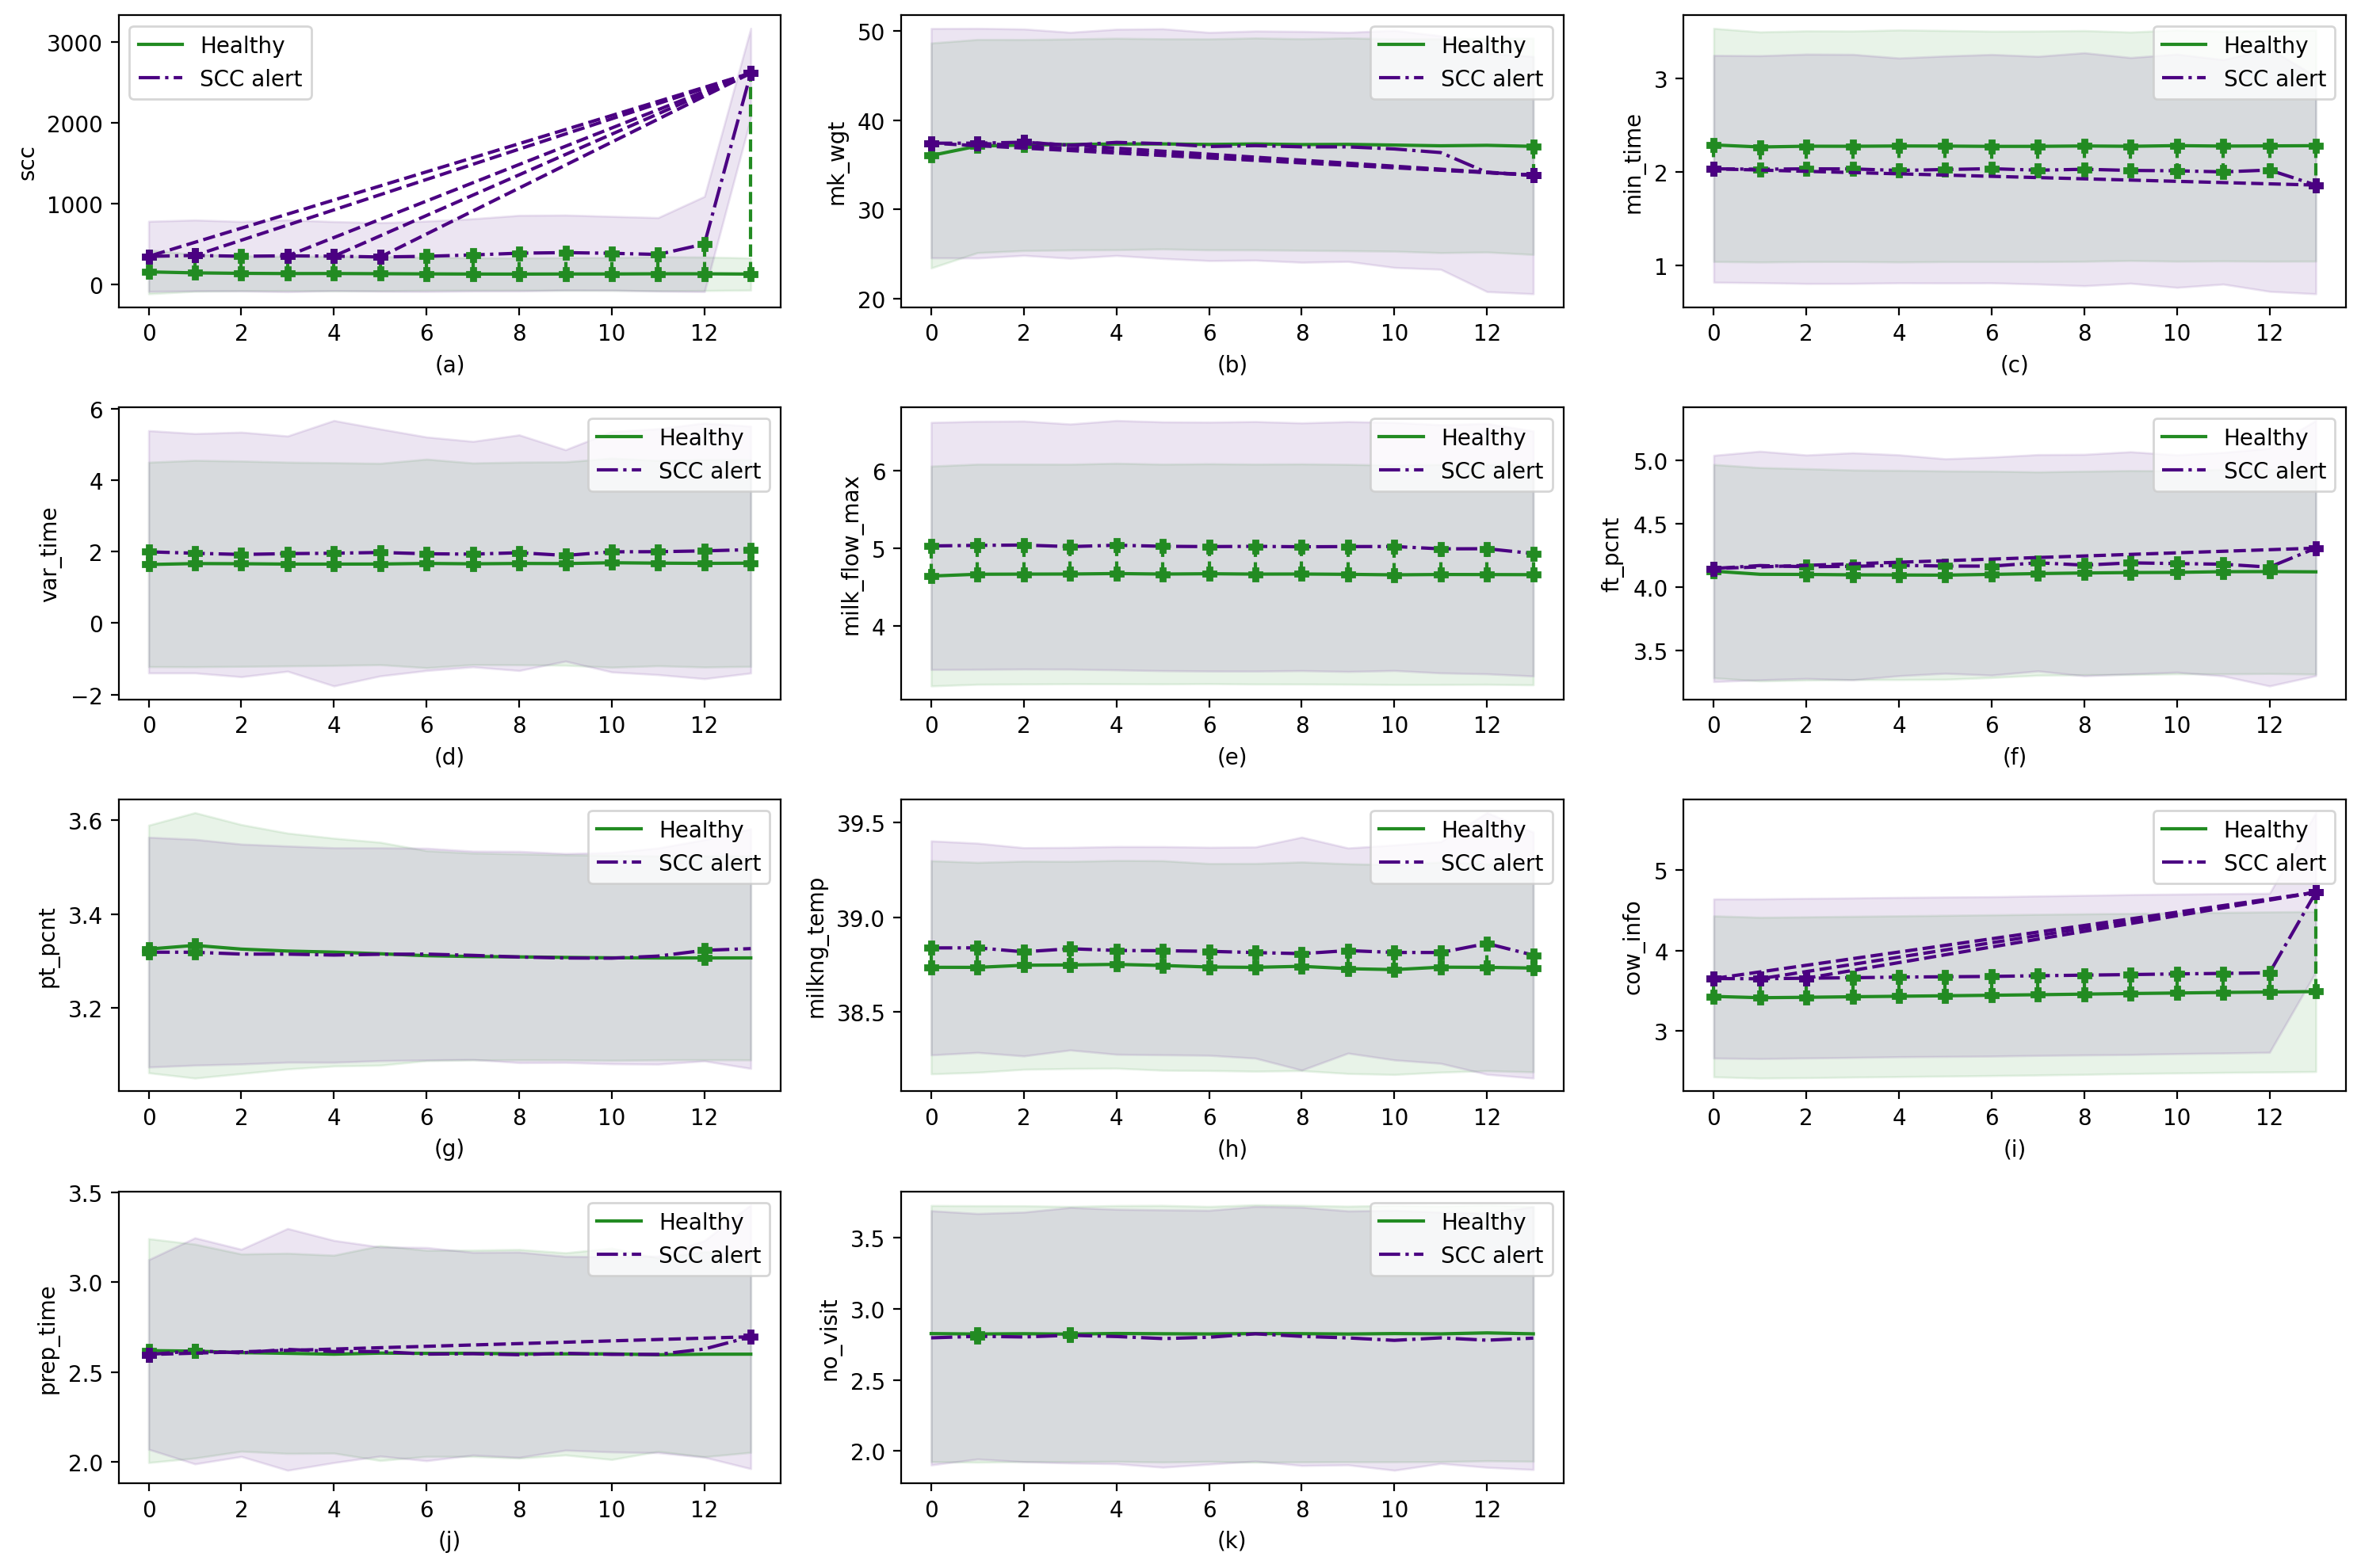

In [23]:
# Create a figure and subplots
fig, axs = plt.subplots(4, 3, figsize=(15, 10), dpi=200)

# Flatten the axs array to iterate over all subplots
axs = axs.flatten()

# looping
for i in range(len(ls_columns_plot)):
    """using func: """
    plot_by_group(X_df, y_df, predictors, period, axs, i)

num_plots = len(ls_columns_plot)
# Hide the empty subplot if present
if num_plots < len(axs):
    axs[-1].axis('off')
    
# Adjust layout and display the figure
plt.tight_layout()
plt.show()



### Concatenate plots 

In [42]:
"""
func:
    function that call visual_by_group

args: 
    path: (str) directory where to find the images
    predictors: list of variable 
    pic_name: name of the final funciton (str) 

return: 
    a picture named pic_name

"""
def concat(path, predictors, pic_name):    

    # first concat vertically
    def concat_vertical(path, predictors, pic_name):
        # init the first image
        figa = plt.imread(path + predictors[0] + '.png')

        # loop through the rest of the image
        for i in range(1, len(predictors)):

            # read in the next image
            figb = plt.imread(path + predictors[i] + '.png')

            # Stitch the two figures together
            figa = np.concatenate((figa,figb), axis=0)

            # Save without a cmap, to preserve the ones you saved earlier
            fname = path + pic_name + ".png"
            plt.imsave(fname, figa)
            
            
    # then concat horizontally
    """using func: """
    concat_vertical(path, predictors[0:3], "one")
    concat_vertical(path, predictors[3:6], "two")
    concat_vertical(path, predictors[6:8], "three")
    concat_vertical(path, predictors[8:], "four")
    
    # read in 
    fig_x = plt.imread(path + "one" + '.png')
    fig_y = plt.imread(path + "two" + '.png')
    fig_z = plt.imread(path + "three" + '.png')
    fig_h = plt.imread(path + "four" + '.png')
    
    # concat 
    pad = np.zeros((800, 1200, 4))
    print("shape: ", fig_z.shape)
    fig_z = np.concatenate((fig_z, pad), axis=0)
    fig_h = np.concatenate((fig_h, pad), axis=0)
    fig_final = np.concatenate((fig_x, fig_y, fig_z, fig_h), axis=1)
    # save
    fname = path + pic_name + ".png"
    plt.imsave(fname, fig_final)

In [43]:
print("Concatenating X_df_with_var...")
pic_name = 'X_df_with_var'
predictors_plot = ['scc', 'mk_wgt', 'min_time', 'var_time', 'milk_flow_max', 'ft_pcnt', 'pt_pcnt', 'milkng_temp', 'prep_time', 'no_visit']
"""using func: concat"""
concat(path_X_df, predictors_plot, pic_name)

Concatenating X_df_with_var...
shape:  (1600, 1200, 4)


### Try with other periods (e.g. 21 days)

In [219]:
print("setting predictors, period, threshold...")
print("!!! df has to be reload due to the in-place changes...")
predictors = ['scc', 'mk_wgt', 'min_time', 'var_time', 'milk_flow_max', 'ft_pcnt', 'pt_pcnt', 'milkng_temp', 'cow_info', 'prep_time', 'no_visit']
period, threshold = 21, 2000

path_X_df = 'plot/X_df_21/'
pic_name_X_21 = 'X_df_21_all'

path_X_df_de = 'plot/X_df_de_21/'
pic_name_X_de_21 = 'X_df_de_21_all'

setting predictors, period, threshold...
!!! df has to be reload due to the in-place changes...


In [220]:
print("creating X_df, y_df...")
X_df, y_df = chunk_herd(df, period, threshold, predictors)
print("X_df, y_df: ", X_df.shape, y_df.shape)

print("ploting for X_df...")
"""using func: visual_by_group"""
visual_by_group(X_df, y_df, predictors, period, path_X_df, mode='save')

print("Concatenating X_df")
predictors_plot = ['scc', 'mk_wgt', 'min_time', 'var_time', 'milk_flow_max', 'ft_pcnt', 'pt_pcnt', 'milkng_temp', 'prep_time', 'no_visit']
"""using func: concat"""
concat(path_X_df, predictors_plot, pic_name_X_21)

creating X_df, y_df...
X_df, y_df:  (30777, 21, 11) (30777,)
ploting for X_df...
Concatenating X_df


In [221]:
print("creating X_df_de, y_df_de...")
X_df_de, y_df_de = chunk_herd(df_detrend, period, threshold, predictors)
print("X_df_de, y_df_de: ", X_df_de.shape, y_df_de.shape)

print("ploting for X_df_de...")
"""using func: visual_by_group"""
visual_by_group(X_df_de, y_df_de, predictors, period, path_X_df_de, mode='save')

print("Concatenating X_df_de")
predictors_plot = ['scc', 'mk_wgt', 'min_time', 'var_time', 'milk_flow_max', 'ft_pcnt', 'pt_pcnt', 'milkng_temp', 'prep_time', 'no_visit']
"""using func: concat"""
concat(path_X_df_de, predictors_plot, pic_name_X_de_21)

creating X_df_de, y_df_de...
X_df_de, y_df_de:  (30777, 21, 11) (30777,)
ploting for X_df_de...
Concatenating X_df_de


# Try with different t value 

In [74]:
print("First change 0.05 to 0.01... (manually)")

print("setting predictors, period, threshold...")
print("!!! df has to be reload due to the in-place changes...")
predictors = ['scc', 'mk_wgt', 'min_time', 'var_time', 'milk_flow_max', 'ft_pcnt', 'pt_pcnt', 'milkng_temp', 'cow_info', 'prep_time', 'no_visit']
period, threshold = 21, 2000

path_X_df = 'plot/X_df_t00005/'
pic_name_X_21 = 'X_df_t00005_all'

First change 0.05 to 0.01... (manually)
setting predictors, period, threshold...
!!! df has to be reload due to the in-place changes...


In [75]:
print("creating X_df, y_df...")
X_df, y_df = chunk_herd(df, period, threshold, predictors)
print("X_df, y_df: ", X_df.shape, y_df.shape)

print("ploting for X_df...")
"""using func: visual_by_group"""
visual_by_group(X_df, y_df, predictors, period, path_X_df, mode='save')

print("Concatenating X_df")
predictors_plot = ['scc', 'mk_wgt', 'min_time', 'var_time', 'milk_flow_max', 'ft_pcnt', 'pt_pcnt', 'milkng_temp', 'prep_time', 'no_visit']
"""using func: concat"""
concat(path_X_df, predictors_plot, pic_name_X_21)

creating X_df, y_df...
X_df, y_df:  (30953, 21, 11) (30953,)
ploting for X_df...
Concatenating X_df
